In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm 

In [3]:
# Define MDP parameters
actions = (0, 1)  # (0=do nothing, 1=maintenance)
xi = (15, 30, 50) # break threshold per type of component
S = [list(range(x + 1)) for x in xi]
C = tuple([[0, 1]] * x + [[math.inf, 5]] for x in xi)
gamma = 0.9  # Discount factor

In [ ]:
w = [np.zeros((x + 1) * 2) for x in xi]

In [ ]:
# Create feature vector \phi(s,a) for a given comp_type, state s, and action a
def feature_vector(comp_type, s, a):
    length = (xi[comp_type] + 1) * 2  # number of (state, action) combos
    phi = np.zeros(length)
    index = s * 2 + a # 
    phi[index] = 1.0
    return phi

In [ ]:
def choose_action_approx(w, comp_type, s, epsilon):
    if s == xi[comp_type]:
        return 1  # forced maintenance
    if np.random.random() < epsilon:
        return np.random.randint(2)  # random action
    else:
        q0 = np.dot(feature_vector(comp_type, s, 0), w[comp_type])
        q1 = np.dot(feature_vector(comp_type, s, 1), w[comp_type])
        return np.argmax([q0, q1])

Q-learning Episodes: 100%|██████████| 10000/10000 [05:56<00:00, 28.06it/s]


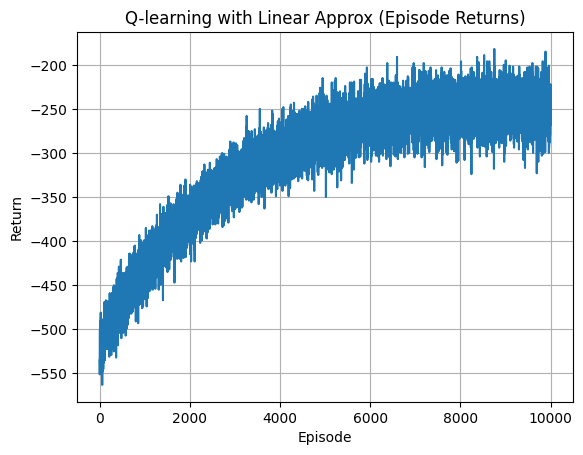


Component Type 0, threshold = 15
Greedy policy: [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), 1]

Component Type 1, threshold = 30
Greedy policy: [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), 1]

Component Type 2, threshold = 50
Greedy policy: [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0),

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm

#############################
## Q-Learning with Linear Approx
#############################

# Global parameters
actions = (0, 1)      # 0 = do nothing, 1 = maintenance
xi = (15, 30, 50)     # break threshold for each component type
gamma = 0.9           # discount factor
p_zero = 0.5          # zero-inflation probability
lambda_poisson = 4    # Poisson mean
dist_name = 'poisson' # distribution for increments

# Cost structure: C[comp_type][state][action]
#  - math.inf if 'do nothing' is not valid (beyond threshold)
#  - 5 if maintenance cost, etc.
C = tuple([[0, 1]] * x + [[math.inf, 5]] for x in xi)

def zero_inflated_prob_vector(p_zero, dist_name, dist_params, s):
    """
    Computes a probability vector for a zero-inflated random variable.
    Last entry is P(X >= s).
    """
    base_dist = getattr(stats, dist_name)
    if s == 0:
        return np.array([p_zero])
    pmf_values = (1 - p_zero) * base_dist.pmf(np.arange(s), *dist_params)
    pmf_values[0] += p_zero
    p_s_or_more = 1 - np.sum(pmf_values)
    return np.append(pmf_values, p_s_or_more)

def feature_vector(comp_type, s, a):
    """
    One-hot encoding for (s, a) given the component type.
    Length = (xi[comp_type] + 1) * 2
    Index = s*2 + a
    """
    length = (xi[comp_type] + 1) * 2
    phi = np.zeros(length)
    idx = s * 2 + a
    phi[idx] = 1.0
    return phi

def choose_action_approx(w, comp_type, s, epsilon):
    """
    Epsilon-greedy action selection using Q(s,a) = phi(s,a)^T w[comp_type].
    If s == xi[comp_type], force action=1 (maintenance).
    """
    if s == xi[comp_type]:
        return 1  # forced maintenance

    # exploration vs. exploitation
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        q0 = np.dot(feature_vector(comp_type, s, 0), w[comp_type])
        q1 = np.dot(feature_vector(comp_type, s, 1), w[comp_type])
        return np.argmax([q0, q1])

def run_q_learning(
    nEpisodes=5000,
    lengthEpisode=100,
    alpha=0.01,
    initial_epsilon=1.0,
    min_epsilon=0.01,
    decay_rate=5000
):
    """
    Runs Q-learning with linear function approximation for our environment.
    Returns the learned weight vectors (w) and the episode returns.
    """

    # 1) Initialize weight vectors for each component type
    w = [np.zeros((x + 1) * 2) for x in xi]  # one w for each type

    episode_returns = []

    # Loop over episodes
    for episode in tqdm(range(nEpisodes), desc="Q-learning Episodes"):
        
        # Decay epsilon
        epsilon = max(min_epsilon, initial_epsilon * np.exp(-episode / decay_rate))

        # Start with a random (or fixed) component type and state=0
        comp_type = np.random.randint(0, 3)
        s = 0
        
        # Keep track of the total reward for this episode
        ep_return = 0.0

        for _ in range(lengthEpisode):
            # 2) Choose action A using epsilon-greedy
            a = choose_action_approx(w, comp_type, s, epsilon)

            # 3) Take action A, observe reward R and next state S'
            if a == 0:  # do nothing
                # random increment from zero-inflated distribution
                prob_vector = zero_inflated_prob_vector(
                    p_zero, dist_name, (lambda_poisson,), xi[comp_type] - s
                )
                increments = np.arange(len(prob_vector))
                increment = np.random.choice(increments, p=prob_vector)
                s_prime = min(s + increment, xi[comp_type])
                comp_type_prime = comp_type
            else:       # maintenance
                s_prime = 0
                comp_type_prime = np.random.randint(0, 3)

            # cost is negative reward
            r = -C[comp_type][s][a]
            ep_return += r

            # 4) Q-learning update
            # 4a) Current Q(s,a)
            phi_sa = feature_vector(comp_type, s, a)
            q_current = np.dot(phi_sa, w[comp_type])

            # 4b) Next-state max Q
            q_next_max = -np.inf
            for a_next in actions:
                phi_next = feature_vector(comp_type_prime, s_prime, a_next)
                q_next = np.dot(phi_next, w[comp_type_prime])
                if q_next > q_next_max:
                    q_next_max = q_next

            # 4c) TD error
            td_error = r + gamma * q_next_max - q_current

            # 4d) weight update
            w[comp_type] += alpha * td_error * phi_sa

            # Move to next state
            s = s_prime
            comp_type = comp_type_prime

        # Store the return for plotting
        episode_returns.append(ep_return)

    return w, episode_returns

#############################
## Example usage
#############################

w_learned, returns = run_q_learning(nEpisodes=pow(10,4), lengthEpisode=pow(10,3))
    
# Plot the episode returns to see learning progress
plt.plot(returns)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Q-learning with Linear Approx (Episode Returns)")
plt.grid(True)
plt.show()

# Print out a greedy policy from the learned weights
for ct in range(len(xi)):
    print(f"\nComponent Type {ct}, threshold = {xi[ct]}")
    policy = []
    for state in range(xi[ct] + 1):
        # forced maintenance if state=xi[ct]
        if state == xi[ct]:
            policy.append(1)
        else:
            q0 = np.dot(feature_vector(ct, state, 0), w_learned[ct])
            q1 = np.dot(feature_vector(ct, state, 1), w_learned[ct])
            policy.append(np.argmax([q0, q1]))
    print("Greedy policy:", [int(x) for x in policy])


In [6]:
# Print out a greedy policy from the learned weights
for ct in range(len(xi)):
    print(f"\nComponent Type {ct}, threshold = {xi[ct]}")
    policy = []
    for state in range(xi[ct] + 1):
        # forced maintenance if state=xi[ct]
        if state == xi[ct]:
            policy.append(1)
        else:
            q0 = np.dot(feature_vector(ct, state, 0), w_learned[ct])
            q1 = np.dot(feature_vector(ct, state, 1), w_learned[ct])
            policy.append(np.argmax([q0, q1]))
    print("Greedy policy:", [int(x) for x in policy])


Component Type 0, threshold = 15
Greedy policy: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

Component Type 1, threshold = 30
Greedy policy: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

Component Type 2, threshold = 50
Greedy policy: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


## Trial 2 

Episodes:   0%|          | 200/100000 [00:08<1:09:48, 23.83it/s]

Stopped early at episode 201 — policy stable for 200 episodes.


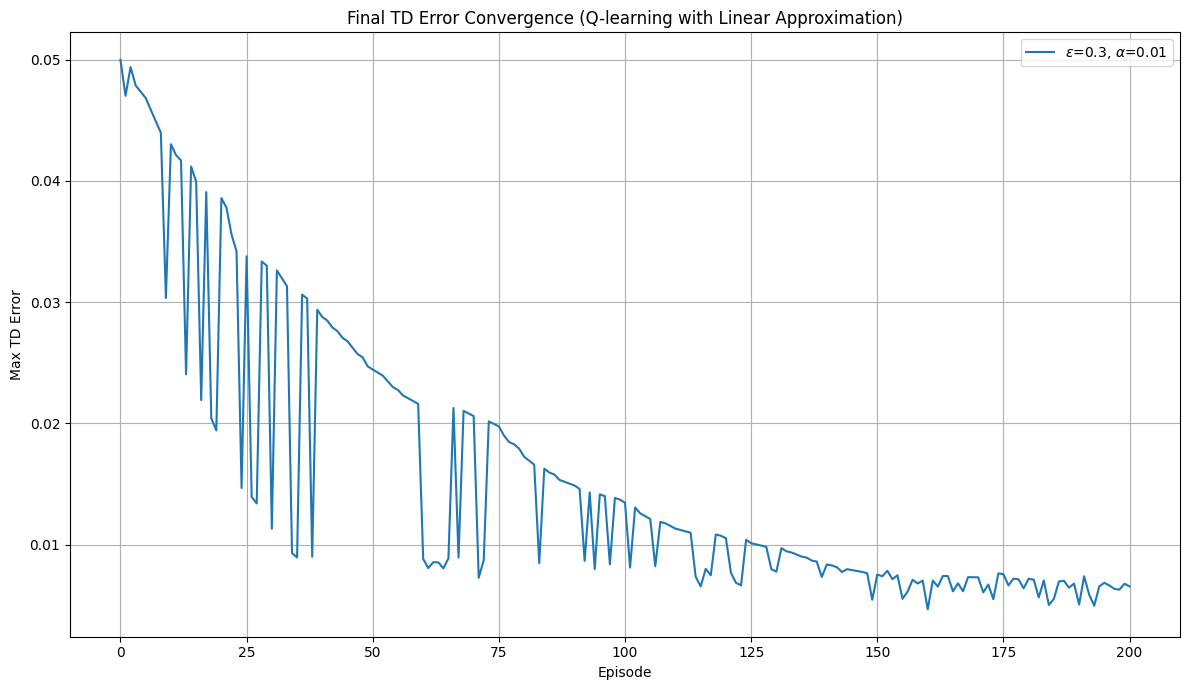

Optimal Policy (0 = Do nothing, 1 = Maintenance):

Component Type 1 (Failure Threshold = 15):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]

Component Type 2 (Failure Threshold = 30):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]

Component Type 3 (Failure Threshold = 50):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1]

Approximated Q-values for each Component Type (for each state, best action value):

Component Type 1 (Failure Threshold = 15):
[[ 0.         -1.        ]
 [ 0.         -0.71503518]
 [ 0.         -0.95198225]
 [ 0.         -0.98894701]
 [ 0.         -0.9911198 ]
 [ 0.         -0.98778909]
 [ 0.         -0.97435305]
 [ 0.         -0.97256467]
 [ 0.         -0.98019382]
 [ 0.         -0.95949426]
 [ 0.         -0.95704629]
 [ 0.         -0.94376552]
 [ 0.         -0.92983416]
 [ 0.         -0.92123739]
 [ 0.         -0.89109823]
 [ 0.         -5.        ]]

Component Type 2 (Failure Threshold = 30):
[[ 0.     

In [10]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm 

# Define MDP parameters (actions, xi, S, C, gamma, etc.) remain the same.
actions = (0, 1)  # (0=do nothing, 1=maintenance)
xi = (15, 30, 50) # break threshold per type of component
S = [list(range(x + 1)) for x in xi]
C = tuple([[0, 1]] * x + [[math.inf, 5]] for x in xi)
gamma = 0.9  # Discount factor

# New function: Feature extraction (one-hot encoding)
def feature_vector(s, comp_type):
    vec = np.zeros(xi[comp_type] + 1)
    vec[s] = 1
    return vec

# Initialize weight matrices instead of Q-tables
def init_weights():
    # Each component type: weight matrix of shape (2, xi[comp_type]+1)
    weights = tuple(np.zeros((2, xi_val + 1)) for xi_val in xi)
    return weights

weights = init_weights()

# Modified epsilon-greedy action selection using linear approximation
def choose_action(weights, comp_type, s, epsilon):
    if s == xi[comp_type]:
        return 1

    features = feature_vector(s, comp_type)
    q_values = [np.dot(weights[comp_type][a], features) for a in range(2)]
    if np.random.random() < epsilon:
        return np.random.randint(2)
    else:
        return np.argmax(q_values)

def run_simulation(nEpisodes, lengthEpisode, initial_epsilon, initial_alpha, min_epsilon=0.01, decay_rate=5000, 
                   delta = 1e-5, patience=None):
    # Use weights for linear function approximation
    weights = init_weights()
    td_errors = []
    
    prev_policy = None
    stable_count = 0
    
    for i in tqdm(range(nEpisodes), desc="Episodes"):
        alpha = initial_alpha / (1 + i / 1000)
        epsilon = max(min_epsilon, initial_epsilon * np.exp(-i / decay_rate))

        comp_type = np.random.randint(0, 3)
        s = S[comp_type][0]
        a = choose_action(weights, comp_type, s, epsilon)
        
        max_td_error = 0
        
        for j in range(lengthEpisode):
            if a == 0:
                prob_vector = zero_inflated_prob_vector(p_zero, dist_name, (lambda_poisson,), xi[comp_type]-s)
                increments = np.arange(len(prob_vector))
                increment = np.random.choice(increments, p=prob_vector)
                s_prime = s + increment
                if s_prime > xi[comp_type]:
                    s_prime = xi[comp_type]
                comp_type_prime = comp_type
            else:
                s_prime = 0
                comp_type_prime = np.random.randint(0, 3)
            
            r = -C[comp_type][s][a]
            
            # Q-learning update:
            current_features = feature_vector(s, comp_type)
            prediction = np.dot(weights[comp_type][a], current_features)
            
            next_features = feature_vector(s_prime, comp_type_prime)
            q_next = [np.dot(weights[comp_type_prime][ap], next_features) for ap in range(2)]
            target = r + gamma * np.max(q_next)
            
            td_error = target - prediction
            weights[comp_type][a] += alpha * td_error * current_features
            
            if abs(alpha * td_error) > max_td_error:
                max_td_error = abs(alpha * td_error)
            
            # Choose next action for simulation progression
            a = choose_action(weights, comp_type_prime, s_prime, epsilon)
            s = s_prime
            comp_type = comp_type_prime
        
        td_errors.append(max_td_error)
        
        # (Optional) Early stopping based on stable policy if needed...
        if patience is not None:
            # Here you may define a policy extraction based on the current weights.
            # For instance, for each comp_type, compute policy(s) = argmax_a Q(s,a)
            current_policy = []
            for comp_type in range(len(weights)):
                policy = []
                for s in range(xi[comp_type]+1):
                    features = feature_vector(s, comp_type)
                    q_values = [np.dot(weights[comp_type][a], features) for a in range(2)]
                    action = np.argmax(q_values)
                    if s == xi[comp_type]:
                        action = 1
                    policy.append(action)
                current_policy.append(np.array(policy))
            if prev_policy is not None and all(np.array_equal(cp, pp) for cp, pp in zip(current_policy, prev_policy)):
                stable_count += 1
                if stable_count >= patience:
                    print(f"Stopped early at episode {i+1} — policy stable for {patience} episodes.")
                    break
            else:
                stable_count = 0
                prev_policy = current_policy
        
        if max_td_error < delta:
            return td_errors, weights
    
    return td_errors, weights

# You can use the same plotting and policy printing functions,
# but adjust them to extract policies from the weight matrices.
def print_policies_and_q_values(weights, label=None):
    if label:
        print(f"\n===== Optimal Policy for {label} =====")
    print("Optimal Policy (0 = Do nothing, 1 = Maintenance):")
    for comp_type in range(len(weights)):
        policy = []
        for s in range(xi[comp_type] + 1):
            features = feature_vector(s, comp_type)
            q_values = [np.dot(weights[comp_type][a], features) for a in range(2)]
            a = np.argmax(q_values)
            # Force maintenance at the threshold
            if s == xi[comp_type]:
                a = 1
            policy.append(a)
        print(f"\nComponent Type {comp_type + 1} (Failure Threshold = {xi[comp_type]}):")
        print(np.array(policy))
    
    print("\nApproximated Q-values for each Component Type (for each state, best action value):")
    for comp_type in range(len(weights)):
        q_vals = []
        for s in range(xi[comp_type] + 1):
            features = feature_vector(s, comp_type)
            q_values = [np.dot(weights[comp_type][a], features) for a in range(2)]
            q_vals.append(q_values)
        print(f"\nComponent Type {comp_type + 1} (Failure Threshold = {xi[comp_type]}):")
        print(np.array(q_vals))

def plot_td_errors(results, title="TD Error Convergence"):
    """
    Utility function to plot results (can be multiple)
    """
    plt.figure(figsize=(12, 7))
    for label, data in results.items():
        plt.plot(data["td_errors"], label=label)

    plt.xlabel("Episode")
    plt.ylabel("Max TD Error")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example final run using the Q-learning with linear approximation
nEpisodes = 10**5
lengthEpisode = 10**3
epsilon = 0.3
alpha = 0.01
td_errors, final_weights = run_simulation(nEpisodes, lengthEpisode, epsilon, alpha, patience=200)

final_results = {f"$\\epsilon$={epsilon}, $\\alpha$={alpha}": {"td_errors": td_errors}}
plot_td_errors(final_results, title="Final TD Error Convergence (Q-learning with Linear Approximation)")
print_policies_and_q_values(final_weights)

## Trial 3

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm 

# ---------------------------
# Utility Functions
# ---------------------------

np.random.seed(0)

def plot_td_errors(results, title="TD Error Convergence"):
    """
    Utility function to plot results (can be multiple)
    """
    plt.figure(figsize=(12, 7))
    for label, data in results.items():
        plt.plot(data["td_errors"], label=label)

    plt.xlabel("Episode")
    plt.ylabel("Max TD Error")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def print_policies_and_q_values(w, feature_dim, xi):
    """
    Utility function to print the derived policy and corresponding Q values.
    The policy is derived by choosing the action that maximizes Q for each state.
    """
    # Determine state counts for each component type
    # comp_type 0: states 0 to xi[0]
    # comp_type 1: states 0 to xi[1]
    # comp_type 2: states 0 to xi[2]
    offsets = [0, xi[0] + 1, xi[0] + 1 + xi[1] + 1]
    
    print("\n===== Derived Policies =====")
    for comp_type in range(len(xi)):
        n_states = xi[comp_type] + 1  # states 0...xi[comp_type]
        policy = np.zeros(n_states, dtype=int)
        q_values = np.zeros((2, n_states))
        for s in range(n_states):
            # Compute Q-value for both actions using the weight vector
            q0 = get_q_value(w, comp_type, s, 0, xi)
            q1 = get_q_value(w, comp_type, s, 1, xi)
            q_values[0, s] = q0
            q_values[1, s] = q1
            # Force maintenance if s is at threshold:
            if s == xi[comp_type]:
                policy[s] = 1
            else:
                policy[s] = 0 if q0 >= q1 else 1
        print(f"\nComponent Type {comp_type + 1} (Failure Threshold = {xi[comp_type]}):")
        print("Optimal Policy (0 = Do nothing, 1 = Maintenance):")
        print(policy)
        print("Q-values (rows: action 0 then action 1):")
        print(q_values)

# ---------------------------
# MDP Parameters
# ---------------------------

actions = (0, 1)  # (0=do nothing, 1=maintenance)
xi = (15, 30, 50)  # failure thresholds per component type
# S is now defined implicitly by the range of states 0 ... xi[comp_type]
# Cost matrix C: for each component type, cost for (do nothing, maintenance) per state
# We assume the following structure: cost is a list for each state and each action.
# Here, we define cost as in the original code: for each state s, 
# action 0 has cost 0 (or 1) and action 1 has cost 5 (or a high cost) when beyond threshold.
C = tuple([[0, 1]] * x + [[math.inf, 5]] for x in xi)
gamma = 0.9  # Discount factor

# ---------------------------
# Transition and Environment Functions
# ---------------------------

p_zero = 0.5  # 50% probability of zero inflation
dist_name = 'poisson'  # Base distribution
lambda_poisson = 4  # Poisson mean

def zero_inflated_prob_vector(p_zero, dist_name, dist_params, s):
    """
    Computes a probability vector for a zero-inflated random variable.
    s: threshold for "s or greater" category.
    """
    base_dist = getattr(stats, dist_name)

    if s == 0:
        prob_vector = [p_zero]
    else:
        pmf_values = (1 - p_zero) * base_dist.pmf(np.arange(s), *dist_params)
        pmf_values[0] += p_zero  # adjust for zero inflation
        p_s_or_more = 1 - np.sum(pmf_values)
        prob_vector = np.append(pmf_values, p_s_or_more)
    return prob_vector

# ---------------------------
# Linear Function Approximation Components
# ---------------------------

# We use a one-hot feature representation for (comp_type, state, action)
# We must map each (comp_type, s, a) to a unique index in the weight vector.
# For component type 0: states 0..xi[0] => xi[0]+1 states
# For comp_type 1: states 0..xi[1] => xi[1]+1 states
# For comp_type 2: states 0..xi[2] => xi[2]+1 states
# Total states = (xi[0]+1) + (xi[1]+1) + (xi[2]+1)
state_counts = [xi[i] + 1 for i in range(len(xi))]
total_states = sum(state_counts)
feature_dim = total_states * 2  # two actions per state

def state_offset(comp_type, s):
    """
    Returns the index offset for a given (comp_type, s) in the overall state vector.
    """
    if comp_type == 0:
        return s
    elif comp_type == 1:
        return state_counts[0] + s
    else:  # comp_type == 2
        return state_counts[0] + state_counts[1] + s

def get_index(comp_type, s, a):
    """
    Maps (comp_type, s, a) to a unique integer in [0, feature_dim).
    """
    return 2 * state_offset(comp_type, s) + a

def feature_vector(comp_type, s, a):
    """
    Returns a one-hot feature vector of dimension feature_dim.
    """
    x = np.zeros(feature_dim)
    idx = get_index(comp_type, s, a)
    x[idx] = 1.0
    return x

def get_q_value(w, comp_type, s, a, xi):
    """
    Computes Q_w(s,a) = w^T x(s,a)
    """
    x = feature_vector(comp_type, s, a)
    return np.dot(w, x)

# ---------------------------
# Action Selection using Epsilon-Greedy
# ---------------------------

def choose_action(w, comp_type, s, xi, epsilon):
    """
    Choose an action using an epsilon-greedy policy based on Q_w.
    Force maintenance (action 1) if s is at the threshold.
    """
    if s == xi[comp_type]:
        return 1

    if np.random.rand() < epsilon:
        return np.random.randint(2)  # random action: 0 or 1
    else:
        q0 = get_q_value(w, comp_type, s, 0, xi)
        q1 = get_q_value(w, comp_type, s, 1, xi)
        return 0 if q0 >= q1 else 1

# ---------------------------
# Q-Learning with Linear Function Approximation Simulation
# ---------------------------

def run_simulation_qlearning_linear(nEpisodes, lengthEpisode, initial_epsilon, initial_alpha, 
                                    min_epsilon=0.01, decay_rate=5000, delta=1e-5, patience=None):
    # Initialize weight vector for linear approximation
    w = np.zeros(feature_dim)
    td_errors = []
    
    # For early stopping based on a stable policy (optional)
    prev_policy = None
    stable_count = 0
    
    for i in tqdm(range(nEpisodes), desc="Episodes"):
        # Decay learning rate and epsilon over episodes
        alpha = initial_alpha / (1 + i / 1000)
        epsilon = max(min_epsilon, initial_epsilon * np.exp(-i / decay_rate))
        
        # Initialize environment: choose a random component type and set state to 0
        comp_type = np.random.randint(0, len(xi))
        s = 0
        
        # Choose initial action using epsilon-greedy on Q_w
        a = choose_action(w, comp_type, s, xi, epsilon)
        max_td_error = 0
        
        for j in range(lengthEpisode):
            # Environment transition dynamics
            # If action is "do nothing" (0), use zero-inflated increments; else, maintenance resets state.
            if a == 0:
                # Compute increment probability vector based on the remaining capacity (xi[comp_type]-s)
                prob_vector = zero_inflated_prob_vector(p_zero, dist_name, (lambda_poisson,), xi[comp_type]-s)
                increments = np.arange(len(prob_vector))
                increment = np.random.choice(increments, p=prob_vector)
                s_prime = s + increment
                if s_prime > xi[comp_type]:
                    s_prime = xi[comp_type]
                comp_type_prime = comp_type
            else:
                # Maintenance: resets state to 0 and randomly switches component type
                s_prime = 0
                comp_type_prime = np.random.randint(0, len(xi))
            
            # Reward (negative cost)
            r = -C[comp_type][s][a]
            
            # Q-Learning target: use max_{a'} Q_w(s',a')
            q_next_0 = get_q_value(w, comp_type_prime, s_prime, 0, xi)
            q_next_1 = get_q_value(w, comp_type_prime, s_prime, 1, xi)
            q_next = max(q_next_0, q_next_1)
            
            q_current = get_q_value(w, comp_type, s, a, xi)
            td_error = r + gamma * q_next - q_current
            
            # Update the weight vector: w <- w + alpha * td_error * ∇_w Q_w(s,a)
            # For linear approximation, ∇_w Q_w(s,a) = feature_vector(s,a)
            x_sa = feature_vector(comp_type, s, a)
            w += alpha * td_error * x_sa
            
            if abs(alpha * td_error) > max_td_error:
                max_td_error = abs(alpha * td_error)
            
            # Prepare for the next step
            s = s_prime
            comp_type = comp_type_prime
            a = choose_action(w, comp_type, s, xi, epsilon)
        
        td_errors.append(max_td_error)
        
        # Optional: Early stopping based on policy stability
        if patience is not None:
            # Construct current greedy policy for each component type based on Q_w
            current_policy = []
            for ct in range(len(xi)):
                n_states = xi[ct] + 1
                policy = np.zeros(n_states, dtype=int)
                for s_val in range(n_states):
                    if s_val == xi[ct]:
                        policy[s_val] = 1
                    else:
                        q0 = get_q_value(w, ct, s_val, 0, xi)
                        q1 = get_q_value(w, ct, s_val, 1, xi)
                        policy[s_val] = 0 if q0 >= q1 else 1
                current_policy.append(policy)
            # Check if policy is stable
            if prev_policy is not None and all(np.array_equal(cp, pp) for cp, pp in zip(current_policy, prev_policy)):
                stable_count += 1
                if stable_count >= patience:
                    print(f"Stopped early at episode {i+1} — policy stable for {patience} episodes.")
                    break
            else:
                stable_count = 0
                prev_policy = current_policy
        
        # Early stopping if TD error is below threshold
        if max_td_error < delta:
            print(f"Converged early at episode {i+1} with TD error < {delta}")
            break

    return td_errors, w

# ---------------------------
# Running the Simulation
# ---------------------------

# Hyperparameters for the final run
nEpisodes = 10**5
lengthEpisode = 10**3
initial_epsilon = 0.3
initial_alpha = 0.3

td_errors, w = run_simulation_qlearning_linear(nEpisodes, lengthEpisode, initial_epsilon, initial_alpha, patience=200)
final_results = {f"$\\epsilon$={initial_epsilon}, $\\alpha$={initial_alpha}": {"td_errors": td_errors}}
plot_td_errors(final_results, title="Final TD Error Convergence")
print_policies_and_q_values(w, feature_dim, xi)
